In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

Set *Axlmutants_Erl_F154* or *Axlmutants_Erl* to **True** in order to use these data.

In [3]:
ABC = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=False, log2T=True, mc_row=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T
info = ABC.iloc[:, :7]

### Phenotypes

#### Cell Viability (from luminex...):

In [5]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv')
# Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv').T

Y_cv = Y_cv.iloc[:, 0:10].div(Y_cv.iloc[:, 0], axis=0).iloc[0, :].T

# Y_cv = Y_cv.iloc[:, 0:10].sub(Y_cv.iloc[:, 0:10].mean(axis=1), axis=0).T

assert data.shape[0] == Y_cv.shape[0]

# Chained MS mixed clustering + PLSR analysis

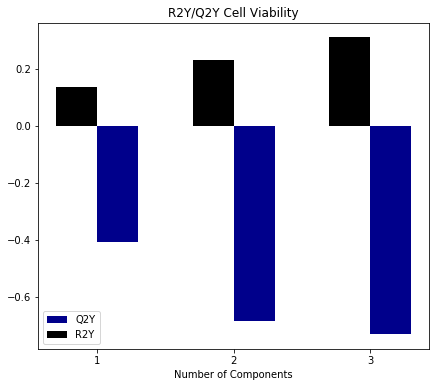

In [6]:
distance_method = "Binomial"
ncl = 3
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [8]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

In [9]:
data

,0,1,2,3,4,5,6,7,8,10,...,348,349,350,351,353,354,355,356,357,358
PC9 A,0.146277,-0.108045,-0.086052,0.056686,-0.905683,0.450394,0.057673,0.538261,0.242877,0.721179,...,0.257361,0.859612,-0.487781,0.959928,0.919313,0.179742,0.016755,-0.074355,1.827761,0.100310
KO A,-0.452506,-0.476332,-0.094996,0.139572,-0.264555,-0.024163,-0.314513,-0.450822,0.226631,-1.069889,...,-0.425614,-0.262110,0.064745,-0.907931,0.008038,-0.054978,-0.257981,-0.515988,-0.517926,-0.162206
Kd A,-0.212346,-0.321637,-0.173403,-0.020027,0.166887,-0.203233,-0.017202,-0.459012,-0.140038,-0.432169,...,0.350455,-0.060600,-0.002907,-0.033116,-0.628323,-0.171872,-0.030810,-0.201335,0.198717,-0.101448
KI A,-0.322889,-0.239781,-0.185023,0.035964,0.990224,-0.619397,-0.476124,-0.225807,-0.402742,0.246437,...,-1.093537,-0.839266,0.089289,-0.481825,-0.065899,0.065117,0.059514,-0.397876,-0.828027,0.309246
M4 A,0.265081,0.126419,-0.079203,-0.440089,-0.256346,0.103645,-0.254137,0.038061,-0.033013,0.267770,...,0.455473,0.114222,-0.107221,0.436319,-0.067763,0.023957,0.026103,0.165137,0.168553,0.015126
M5 A,0.025052,0.274226,0.107230,-0.006117,0.239761,-0.157415,0.050336,-0.089086,0.011860,0.015784,...,-0.589032,-0.483345,0.594054,-0.163870,0.441085,0.160009,-0.154214,-0.274107,-0.332408,-0.096736
M7 A,0.304444,0.243800,-0.124472,-0.069619,-0.126352,-0.012527,0.149402,0.150254,0.085925,0.185314,...,0.153639,0.351645,-0.050929,0.024939,-0.160495,0.114581,0.175585,0.255818,0.398107,0.080621
M10 A,0.039775,0.210842,0.160896,0.003662,0.681401,0.406166,0.289132,0.337667,0.126432,0.205212,...,0.441497,0.171101,-0.161403,0.111514,-0.329553,-0.237162,-0.177918,0.379179,0.042446,-0.051630
M11 A,0.132145,0.326859,0.230457,0.209473,-0.332600,0.098905,0.279190,0.160318,-0.122947,0.087689,...,0.177422,0.251626,-0.127804,0.109740,-0.004565,0.088879,0.169410,0.357072,-0.473541,-0.171924
M15 A,0.074967,-0.036352,0.244567,0.090494,-0.192736,-0.042375,0.236245,0.000167,0.005017,-0.227328,...,0.272335,-0.102885,0.189956,-0.055698,-0.111838,-0.168274,0.173557,0.306455,-0.483681,0.078641


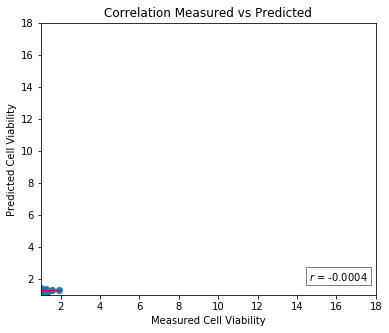

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

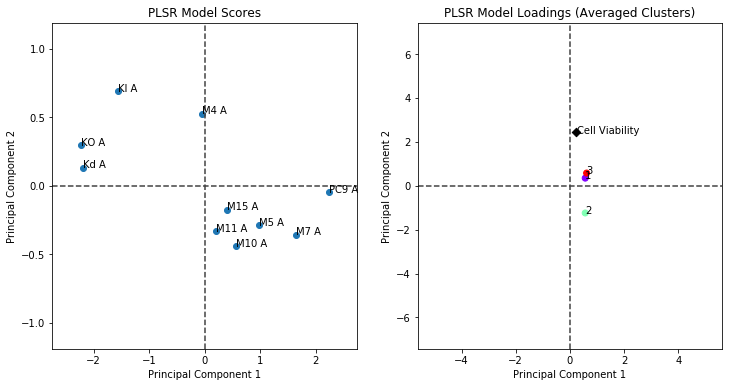

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [12]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C2,r2/Std_C2,BioReps_C2,Prot_C3,abbv_C3,seqs_C3,UniprotAcc_C3,Pos_C3,r2/Std_C3,BioReps_C3
0,40S ribosomal protein S27,Y31-p,QSPNSyFMDVK,P42677,RPS27,1,N/A,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",Y771-p,TAEPDyGALYE,...,PLCG1,1,N/A,40S ribosomal protein S3,Y120-p,VRRACyGVLRF,P23396,RPS3,1,N/A
1,Aldo-keto reductase family 1 member B1,Y178-p,KPGLKyKPAVN,P15121,AKR1B1,1,N/A,26S proteasome regulatory subunit 4,Y25-p,DKKKKyEPPVP,...,PSMC1,1,N/A,60S ribosomal protein L10a,Y11-p,SRDTLyEAVRE,P62906,RPL10A,1,N/A
2,Breast cancer anti-estrogen resistance protein 3,Y212-p,RLSEAySRVQY,O75815,BCAR3,1,N/A,40S ribosomal protein SA,Y139-p,LTEASyVNLPT,...,RPSA,1,N/A,60S ribosomal protein L15,Y59-p,KAKQGyVIYRI,P61313,RPL15,1,N/A
3,Calmodulin-1,Y100-p,KDGNGyISAAE,P0DP23,CALM1,1,N/A,60S ribosomal protein L35a,Y34-p,KIEGVyARDET,...,RPL35A,1,N/A,Abl interactor 2,Y213-p,VVPNDyVPSPT,Q9NYB9,ABI2,1,N/A
4,Catenin delta-1,Y280-p,FHPEPyGLEDD,O60716,CTNND1,1,N/A,ATPase WRNIP1,Y500-p,AGEEHyNCISA,...,WRNIP1,1,N/A,Adapter molecule crk,Y136-p,QEEAEyVRALF,P46108,CRK,1,N/A
5,Cofilin-1,Y140-p,LQANCyEEVKD,P23528,CFL1,1,N/A,Actin filament-associated protein 1-like 2,Y56-p,DEEYIyMNKVT,...,AFAP1L2,1,N/A,Annexin A1,Y207-p,DARALyEAGER,P04083,ANXA1,1,N/A
6,Elongation factor 1-alpha 1,Y141-p,HALLAyTLGVK,P68104,EEF1A1,1,N/A,"Actin, cytoplasmic 1",Y198-p,LTERGySFTTT,...,ACTB,1,N/A,Band 4.1-like protein 1,Y343-p,IRPGEyEQFES,Q9H4G0,EPB41L1,1,N/A
7,Focal adhesion kinase 1,Y570-p,FGLSRyMEDST,Q05397,PTK2,2,0.85,Activated CDC42 kinase 1,Y518-p,VKKPTyDPVSE,...,TNK2,1,N/A,Band 4.1-like protein 2,Y623-p,EGDNIyVRHSN,O43491,EPB41L2,2,0.68
8,Glutathione S-transferase P,Y104-p,DLRCKyISLIY,P09211,GSTP1,1,N/A,Afadin,Y1230-p,TYTREyFTFPA,...,AFDN,1,N/A,Breast cancer anti-estrogen resistance protein 3,Y117-p,DPTVEyVKFSK,O75815,BCAR3,2,0.95
9,Glycosaminoglycan xylosylkinase,Y138-p,VEGEPyAGYDR,O75063,FAM20B,1,N/A,Alpha-actinin-1,Y215-p,DVAEKyLDIPK,...,ACTN1,1,N/A,CTP synthase 1,Y473-p,YGDADyLEERH,P17812,CTPS1,1,N/A


In [13]:
create_download_link(clustermembers, "DataClustering")

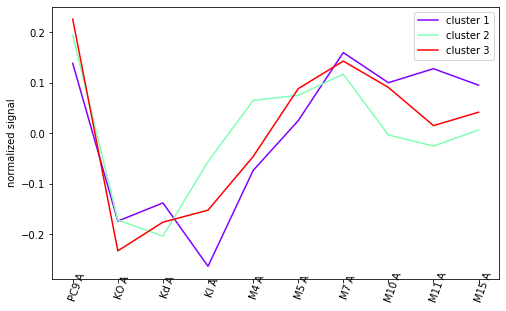

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, ncl)

In [15]:
ABC

,Protein,Sequence,UniprotAcc,Abbv,Position,BioReps,r2_Std,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
0,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",TAEPDyGALYE,P19174,PLCG1,Y771-p,1,N/A,0.146277,-0.452506,-0.212346,-0.322889,0.265081,0.025052,0.304444,0.039775,0.132145,0.074967
1,26S proteasome regulatory subunit 4,DKKKKyEPPVP,P62191,PSMC1,Y25-p,1,N/A,-0.108045,-0.476332,-0.321637,-0.239781,0.126419,0.274226,0.243800,0.210842,0.326859,-0.036352
2,40S ribosomal protein S27,QSPNSyFMDVK,P42677,RPS27,Y31-p,1,N/A,-0.086052,-0.094996,-0.173403,-0.185023,-0.079203,0.107230,-0.124472,0.160896,0.230457,0.244567
3,40S ribosomal protein S3,VRRACyGVLRF,P23396,RPS3,Y120-p,1,N/A,0.056686,0.139572,-0.020027,0.035964,-0.440089,-0.006117,-0.069619,0.003662,0.209473,0.090494
4,40S ribosomal protein SA,LTEASyVNLPT,P08865,RPSA,Y139-p,1,N/A,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,Uncharacterized protein KIAA1671,RIEPRyDIVHA,Q9BY89,KIAA1671,Y733-p,1,N/A,0.179742,-0.054978,-0.171872,0.065117,0.023957,0.160009,0.114581,-0.237162,0.088879,-0.168274
355,Vasodilator-stimulated phosphoprotein,SRVQIyHNPTA,P50552,VASP,Y39-p,1,N/A,0.016755,-0.257981,-0.030810,0.059514,0.026103,-0.154214,0.175585,-0.177918,0.169410,0.173557
356,Vinculin,GNQAAyEHFET,P18206,VCL,Y692-p,2,0.63,-0.074355,-0.515988,-0.201335,-0.397876,0.165137,-0.274107,0.255818,0.379179,0.357072,0.306455
357,Zinc finger protein 185,LFVKEyVNASE,O15231,ZNF185,Y581-p,1,N/A,1.827761,-0.517926,0.198717,-0.828027,0.168553,-0.332408,0.398107,0.042446,-0.473541,-0.483681
